<a href="https://colab.research.google.com/github/realfolkcode/GraphRegression/blob/main/hyperpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import scipy
from scipy.sparse.linalg import cg
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
!pip install pickle5

     |████████████████████████████████| 256 kB 5.5 MB/s 


In [3]:
import pickle5 as pickle

In [4]:
!git clone https://github.com/realfolkcode/GraphRegression.git

Cloning into 'GraphRegression'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [5]:
from GraphRegression.utils import set_random_seeds
from GraphRegression.hypergraph import hyper_propagation

# Prepare Data

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
#graphs_dir = '/gdrive/MyDrive/research/67data'
graphs_dir = '/gdrive/MyDrive/research/processed_data'

In [8]:
X = []
y = []

idx = 0
idx_train = []
idx_val = []
idx_test = []

In [9]:
#file_name = os.path.join(graphs_dir + '/63k_train.pkl')
file_name = os.path.join(graphs_dir + '/pdbbind2016_train.pkl')
with open(file_name, 'rb') as f:
    data_mols, data_Y = pickle.load(f)

for mol, target in tqdm(zip(data_mols, data_Y)):
    X.append(mol[4])
    y.append(target)
    idx_train.append(idx)
    idx += 1

3390it [00:00, 937228.30it/s]


In [10]:
#file_name = os.path.join(graphs_dir + '/63k_val.pkl')
file_name = os.path.join(graphs_dir + '/pdbbind2016_val.pkl')
with open(file_name, 'rb') as f:
    data_mols, data_Y = pickle.load(f)

for mol, target in tqdm(zip(data_mols, data_Y)):
    X.append(mol[4])
    y.append(target)
    idx_val.append(idx)
    idx += 1

377it [00:00, 184144.94it/s]


In [11]:
#file_name = os.path.join(graphs_dir + '/63k_test.pkl')
file_name = os.path.join(graphs_dir + '/pdbbind2016_test.pkl')
with open(file_name, 'rb') as f:
    data_mols, data_Y = pickle.load(f)

for mol, target in tqdm(zip(data_mols, data_Y)):
    X.append(mol[4])
    y.append(target)
    idx_test.append(idx)
    idx += 1

290it [00:00, 246074.89it/s]


In [12]:
X = np.array(X)
X = preprocessing.normalize(X, norm='l1')
y = np.array(y).reshape(-1, 1)

In [13]:
print('Train size:', len(idx_train))
print('Val size:', len(idx_val))
print('Test size:', len(idx_test))

Train size: 3390
Val size: 377
Test size: 290


In [14]:
idx_train_val = np.hstack((idx_train, idx_val))

# Baselines

## Linear Regression

In [40]:
lr = Ridge(alpha=0.01, random_state=42)
lr.fit(X[idx_train], y[idx_train])

Ridge(alpha=0.01, random_state=42)

In [41]:
pred_train = lr.predict(X[idx_train])
pred_val = lr.predict(X[idx_val])
pred_test = lr.predict(X[idx_test])

In [42]:
train_rmse = mean_squared_error(y[idx_train], pred_train, squared=False)
val_rmse = mean_squared_error(y[idx_val], pred_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], pred_test, squared=False)

In [43]:
print('Train RMSE:', train_rmse)
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 1.8660152909597172
Val RMSE: 1.8392764375861368
Test RMSE: 2.094580670979875


In [44]:
n_neighbors_space = np.arange(1, 101)
val_rmse = []
best_rmse = 1e9
best_n_neighbors = n_neighbors_space[0]
for n_neighbors in tqdm(n_neighbors_space):
    z = hyper_propagation(X, y[idx_train], idx_train, idx_val, n_neighbors, pred_train=pred_train, pred_test=pred_val)
    val_rmse.append(mean_squared_error(y[idx_val], z, squared=False))
    if val_rmse[-1] < best_rmse:
        best_n_neighbors = n_neighbors
        best_rmse = val_rmse[-1]

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


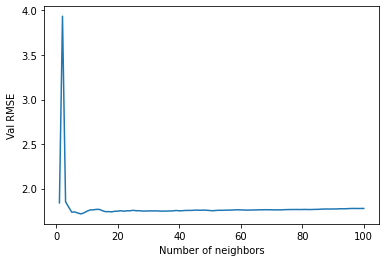

In [46]:
plt.plot(n_neighbors_space, val_rmse)
plt.xlabel('Number of neighbors')
plt.ylabel('Val RMSE')
plt.show()

In [47]:
print('Best K Neighbors:', best_n_neighbors)

Best K Neighbors: 8


In [50]:
z_val = hyper_propagation(X, y[idx_train], idx_train, idx_val, best_n_neighbors, pred_train=pred_train, pred_test=pred_val)
z_test = hyper_propagation(X, y[idx_train], idx_train, idx_test, best_n_neighbors, pred_train=pred_train, pred_test=pred_test)

In [51]:
val_rmse = mean_squared_error(y[idx_val], z_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], z_test, squared=False)

In [52]:
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Val RMSE: 1.71523954815663
Test RMSE: 2.026381158349921


## MLP

In [53]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 0

In [54]:
class MLP(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(n_in, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
        )
        self.regressor = nn.Linear(16, 1)
    
    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x
    
    def get_emb(self, x):
        x = self.features(x)
        return x

In [55]:
def epoch_train(model, loader, criterion, opt):
    train_loss = 0
    model.train()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item() * len(target)
    train_loss /= len(loader.dataset)
    return train_loss

In [56]:
def epoch_val(model, loader, criterion):
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item() * len(target)
    val_loss /= len(loader.dataset)
    return val_loss

In [57]:
set_random_seeds(seed_value=RANDOM_SEED, device=device)

mlp = MLP(36).to(device)

In [58]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(mlp.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.5)

In [59]:
batch_size = 128

train_loader = DataLoader(TensorDataset(torch.Tensor(X[idx_train]), torch.Tensor(y[idx_train])), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.Tensor(X[idx_val]), torch.Tensor(y[idx_val])), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.Tensor(X[idx_test]), torch.Tensor(y[idx_test])), batch_size=batch_size, shuffle=False)

In [60]:
num_epochs = 300

train_loss = []
val_loss = []
best_epoch = 0
best_loss = 1e9

for i in tqdm(range(num_epochs)):
    loss = np.sqrt(epoch_train(mlp, train_loader, criterion, opt))
    train_loss.append(loss)

    loss = np.sqrt(epoch_val(mlp, val_loader, criterion))
    val_loss.append(loss)
    if loss < best_loss:
        best_epoch = i
        best_loss = loss
    
    scheduler.step()
    
    print('---------------------------------------------------------')
    print(f'Epoch: {i}, Train RMSE: {train_loss[-1]}, Val RMSE: {val_loss[-1]}, Best RMSE: {best_loss}')

  1%|          | 3/300 [00:00<00:27, 10.95it/s]

---------------------------------------------------------
Epoch: 0, Train RMSE: 3.2550669093771862, Val RMSE: 1.9663318982520197, Best RMSE: 1.9663318982520197
---------------------------------------------------------
Epoch: 1, Train RMSE: 1.9996105868528165, Val RMSE: 1.8784684938958152, Best RMSE: 1.8784684938958152
---------------------------------------------------------
Epoch: 2, Train RMSE: 1.9214836661383394, Val RMSE: 1.8627831398170884, Best RMSE: 1.8627831398170884
---------------------------------------------------------
Epoch: 3, Train RMSE: 1.9180791837881894, Val RMSE: 1.8535261262659846, Best RMSE: 1.8535261262659846


  2%|▏         | 7/300 [00:00<00:19, 14.97it/s]

---------------------------------------------------------
Epoch: 4, Train RMSE: 1.9025559054425203, Val RMSE: 1.8467756853681994, Best RMSE: 1.8467756853681994
---------------------------------------------------------
Epoch: 5, Train RMSE: 1.901182781150128, Val RMSE: 1.845148027546661, Best RMSE: 1.845148027546661
---------------------------------------------------------
Epoch: 6, Train RMSE: 1.8976336850455826, Val RMSE: 1.8446233377402033, Best RMSE: 1.8446233377402033
---------------------------------------------------------
Epoch: 7, Train RMSE: 1.8930024212265213, Val RMSE: 1.8909934364107026, Best RMSE: 1.8446233377402033


  4%|▎         | 11/300 [00:00<00:17, 16.75it/s]

---------------------------------------------------------
Epoch: 8, Train RMSE: 1.9054553564720778, Val RMSE: 1.846454393657822, Best RMSE: 1.8446233377402033
---------------------------------------------------------
Epoch: 9, Train RMSE: 1.891789493591223, Val RMSE: 1.8466019439848715, Best RMSE: 1.8446233377402033
---------------------------------------------------------
Epoch: 10, Train RMSE: 1.8990584555192938, Val RMSE: 1.8585300871435741, Best RMSE: 1.8446233377402033
---------------------------------------------------------
Epoch: 11, Train RMSE: 1.9305341058442955, Val RMSE: 1.8898179871380825, Best RMSE: 1.8446233377402033


  5%|▌         | 15/300 [00:01<00:17, 16.44it/s]

---------------------------------------------------------
Epoch: 12, Train RMSE: 1.9028394220778688, Val RMSE: 1.8729282016084, Best RMSE: 1.8446233377402033
---------------------------------------------------------
Epoch: 13, Train RMSE: 1.9101538227085966, Val RMSE: 1.8534122934708424, Best RMSE: 1.8446233377402033
---------------------------------------------------------
Epoch: 14, Train RMSE: 1.8961272933678401, Val RMSE: 1.8407080408735679, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 15, Train RMSE: 1.895715512013229, Val RMSE: 1.9042537332040532, Best RMSE: 1.8407080408735679


  6%|▋         | 19/300 [00:01<00:16, 17.28it/s]

---------------------------------------------------------
Epoch: 16, Train RMSE: 1.908248296116359, Val RMSE: 1.8858887130662356, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 17, Train RMSE: 1.8972845977251758, Val RMSE: 1.8593870032948316, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 18, Train RMSE: 1.881588201163575, Val RMSE: 1.847291910307191, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 19, Train RMSE: 1.881392936206361, Val RMSE: 1.9037130273798994, Best RMSE: 1.8407080408735679


  8%|▊         | 23/300 [00:01<00:16, 16.98it/s]

---------------------------------------------------------
Epoch: 20, Train RMSE: 1.8915394858210461, Val RMSE: 1.8482545645303812, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 21, Train RMSE: 1.8881103410345745, Val RMSE: 1.8568781861025874, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 22, Train RMSE: 1.9107713617417503, Val RMSE: 1.8482845108344184, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 23, Train RMSE: 1.881959447966416, Val RMSE: 1.8580830102589576, Best RMSE: 1.8407080408735679


  9%|▉         | 27/300 [00:01<00:15, 17.91it/s]

---------------------------------------------------------
Epoch: 24, Train RMSE: 1.889318158740388, Val RMSE: 1.867362642626616, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 25, Train RMSE: 1.88209761420642, Val RMSE: 1.8467422199363814, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 26, Train RMSE: 1.8826115944987316, Val RMSE: 1.8540636863272688, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 27, Train RMSE: 1.8841822059294364, Val RMSE: 1.8421091946366501, Best RMSE: 1.8407080408735679


 10%|█         | 31/300 [00:01<00:16, 16.50it/s]

---------------------------------------------------------
Epoch: 28, Train RMSE: 1.9095172595169811, Val RMSE: 1.9788034265079133, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 29, Train RMSE: 1.9227337062852607, Val RMSE: 1.884387404797368, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 30, Train RMSE: 1.8909522991250038, Val RMSE: 1.8411844252803893, Best RMSE: 1.8407080408735679
---------------------------------------------------------
Epoch: 31, Train RMSE: 1.8886870177978115, Val RMSE: 1.8405361338194317, Best RMSE: 1.8405361338194317


 12%|█▏        | 35/300 [00:02<00:14, 17.68it/s]

---------------------------------------------------------
Epoch: 32, Train RMSE: 1.8936416981836888, Val RMSE: 1.8414071031219446, Best RMSE: 1.8405361338194317
---------------------------------------------------------
Epoch: 33, Train RMSE: 1.8865219111288438, Val RMSE: 1.843648993077468, Best RMSE: 1.8405361338194317
---------------------------------------------------------
Epoch: 34, Train RMSE: 1.8881163937416958, Val RMSE: 1.8392894424837545, Best RMSE: 1.8392894424837545
---------------------------------------------------------
Epoch: 35, Train RMSE: 1.895074820545144, Val RMSE: 1.852715695532208, Best RMSE: 1.8392894424837545


 13%|█▎        | 39/300 [00:02<00:15, 16.71it/s]

---------------------------------------------------------
Epoch: 36, Train RMSE: 1.9526487309142264, Val RMSE: 1.8458527888225964, Best RMSE: 1.8392894424837545
---------------------------------------------------------
Epoch: 37, Train RMSE: 1.8802808561502538, Val RMSE: 1.8416696619969521, Best RMSE: 1.8392894424837545
---------------------------------------------------------
Epoch: 38, Train RMSE: 1.876434502480956, Val RMSE: 1.8433209987618615, Best RMSE: 1.8392894424837545
---------------------------------------------------------
Epoch: 39, Train RMSE: 1.8833118138271496, Val RMSE: 1.8538126469912937, Best RMSE: 1.8392894424837545


 14%|█▍        | 43/300 [00:02<00:15, 16.75it/s]

---------------------------------------------------------
Epoch: 40, Train RMSE: 1.8854513844253986, Val RMSE: 1.8805501971604761, Best RMSE: 1.8392894424837545
---------------------------------------------------------
Epoch: 41, Train RMSE: 1.9296317786383228, Val RMSE: 1.878738919173449, Best RMSE: 1.8392894424837545
---------------------------------------------------------
Epoch: 42, Train RMSE: 1.8764562677366432, Val RMSE: 1.8392236517888034, Best RMSE: 1.8392236517888034
---------------------------------------------------------
Epoch: 43, Train RMSE: 1.878149238055443, Val RMSE: 1.8390112895847248, Best RMSE: 1.8390112895847248


 16%|█▌        | 47/300 [00:02<00:14, 17.37it/s]

---------------------------------------------------------
Epoch: 44, Train RMSE: 1.8857587925280022, Val RMSE: 1.8777037682890791, Best RMSE: 1.8390112895847248
---------------------------------------------------------
Epoch: 45, Train RMSE: 1.8736919108335, Val RMSE: 1.8404703342576876, Best RMSE: 1.8390112895847248
---------------------------------------------------------
Epoch: 46, Train RMSE: 1.8956725187403165, Val RMSE: 1.8424147303691623, Best RMSE: 1.8390112895847248
---------------------------------------------------------
Epoch: 47, Train RMSE: 1.8800027984334828, Val RMSE: 1.8380817918044772, Best RMSE: 1.8380817918044772


 17%|█▋        | 51/300 [00:03<00:13, 17.91it/s]

---------------------------------------------------------
Epoch: 48, Train RMSE: 1.8938898532833948, Val RMSE: 1.9266676803075709, Best RMSE: 1.8380817918044772
---------------------------------------------------------
Epoch: 49, Train RMSE: 1.8988145719741427, Val RMSE: 1.8407287636300607, Best RMSE: 1.8380817918044772
---------------------------------------------------------
Epoch: 50, Train RMSE: 1.8663862068164963, Val RMSE: 1.8437519592266514, Best RMSE: 1.8380817918044772
---------------------------------------------------------
Epoch: 51, Train RMSE: 1.8648932048877118, Val RMSE: 1.8513252485339153, Best RMSE: 1.8380817918044772


 18%|█▊        | 55/300 [00:03<00:13, 18.13it/s]

---------------------------------------------------------
Epoch: 52, Train RMSE: 1.872380998166509, Val RMSE: 1.8372717996483536, Best RMSE: 1.8372717996483536
---------------------------------------------------------
Epoch: 53, Train RMSE: 1.8596473857638869, Val RMSE: 1.8328150909845176, Best RMSE: 1.8328150909845176
---------------------------------------------------------
Epoch: 54, Train RMSE: 1.8594866342782361, Val RMSE: 1.8362669312871323, Best RMSE: 1.8328150909845176
---------------------------------------------------------
Epoch: 55, Train RMSE: 1.8527499964527474, Val RMSE: 1.8303619007778595, Best RMSE: 1.8303619007778595


 20%|█▉        | 59/300 [00:03<00:13, 18.02it/s]

---------------------------------------------------------
Epoch: 56, Train RMSE: 1.8514420660767739, Val RMSE: 1.8290276642477095, Best RMSE: 1.8290276642477095
---------------------------------------------------------
Epoch: 57, Train RMSE: 1.849458176855816, Val RMSE: 1.8534429611806154, Best RMSE: 1.8290276642477095
---------------------------------------------------------
Epoch: 58, Train RMSE: 1.8533034994014301, Val RMSE: 1.837365148115593, Best RMSE: 1.8290276642477095
---------------------------------------------------------
Epoch: 59, Train RMSE: 1.8472236840132075, Val RMSE: 1.8499444535886675, Best RMSE: 1.8290276642477095


 21%|██        | 63/300 [00:03<00:13, 17.64it/s]

---------------------------------------------------------
Epoch: 60, Train RMSE: 1.8471414687963033, Val RMSE: 1.8267252545482129, Best RMSE: 1.8267252545482129
---------------------------------------------------------
Epoch: 61, Train RMSE: 1.8435023768096621, Val RMSE: 1.8195092771818815, Best RMSE: 1.8195092771818815
---------------------------------------------------------
Epoch: 62, Train RMSE: 1.8458675645292717, Val RMSE: 1.8349927171081473, Best RMSE: 1.8195092771818815
---------------------------------------------------------
Epoch: 63, Train RMSE: 1.8409221653580585, Val RMSE: 1.83252225463707, Best RMSE: 1.8195092771818815


 22%|██▏       | 67/300 [00:03<00:13, 17.71it/s]

---------------------------------------------------------
Epoch: 64, Train RMSE: 1.8685573511962394, Val RMSE: 1.813703313402797, Best RMSE: 1.813703313402797
---------------------------------------------------------
Epoch: 65, Train RMSE: 1.8338703821035764, Val RMSE: 1.81213677480217, Best RMSE: 1.81213677480217
---------------------------------------------------------
Epoch: 66, Train RMSE: 1.8359105839232002, Val RMSE: 1.824827928450793, Best RMSE: 1.81213677480217
---------------------------------------------------------
Epoch: 67, Train RMSE: 1.840509787374604, Val RMSE: 1.8218673886953711, Best RMSE: 1.81213677480217


 24%|██▎       | 71/300 [00:04<00:12, 18.20it/s]

---------------------------------------------------------
Epoch: 68, Train RMSE: 1.8475352509311986, Val RMSE: 1.8294547849812397, Best RMSE: 1.81213677480217
---------------------------------------------------------
Epoch: 69, Train RMSE: 1.8450370677976484, Val RMSE: 1.8117653997903025, Best RMSE: 1.8117653997903025
---------------------------------------------------------
Epoch: 70, Train RMSE: 1.8229600673031066, Val RMSE: 1.8063707260973907, Best RMSE: 1.8063707260973907
---------------------------------------------------------
Epoch: 71, Train RMSE: 1.8373524507364842, Val RMSE: 1.8738800483332467, Best RMSE: 1.8063707260973907


 25%|██▌       | 75/300 [00:04<00:12, 18.14it/s]

---------------------------------------------------------
Epoch: 72, Train RMSE: 1.831400351890821, Val RMSE: 1.8171776361395526, Best RMSE: 1.8063707260973907
---------------------------------------------------------
Epoch: 73, Train RMSE: 1.8404689674060746, Val RMSE: 1.8033625741653783, Best RMSE: 1.8033625741653783
---------------------------------------------------------
Epoch: 74, Train RMSE: 1.826226953100087, Val RMSE: 1.850546048049769, Best RMSE: 1.8033625741653783
---------------------------------------------------------
Epoch: 75, Train RMSE: 1.8425890111572143, Val RMSE: 1.8086524985875714, Best RMSE: 1.8033625741653783


 26%|██▋       | 79/300 [00:04<00:12, 17.70it/s]

---------------------------------------------------------
Epoch: 76, Train RMSE: 1.8221684812853682, Val RMSE: 1.836912399461937, Best RMSE: 1.8033625741653783
---------------------------------------------------------
Epoch: 77, Train RMSE: 1.8323417484860816, Val RMSE: 1.8001986416901368, Best RMSE: 1.8001986416901368
---------------------------------------------------------
Epoch: 78, Train RMSE: 1.8353200291026461, Val RMSE: 1.8024764253858299, Best RMSE: 1.8001986416901368
---------------------------------------------------------
Epoch: 79, Train RMSE: 1.8387277608697734, Val RMSE: 1.8441243802808276, Best RMSE: 1.8001986416901368


 28%|██▊       | 83/300 [00:04<00:11, 18.14it/s]

---------------------------------------------------------
Epoch: 80, Train RMSE: 1.823006637314178, Val RMSE: 1.8008419915934863, Best RMSE: 1.8001986416901368
---------------------------------------------------------
Epoch: 81, Train RMSE: 1.8235848921410371, Val RMSE: 1.796283386876642, Best RMSE: 1.796283386876642
---------------------------------------------------------
Epoch: 82, Train RMSE: 1.8176423482777728, Val RMSE: 1.8001367058841033, Best RMSE: 1.796283386876642
---------------------------------------------------------
Epoch: 83, Train RMSE: 1.816837688838256, Val RMSE: 1.8505997093701003, Best RMSE: 1.796283386876642


 29%|██▉       | 87/300 [00:05<00:11, 18.50it/s]

---------------------------------------------------------
Epoch: 84, Train RMSE: 1.8294038849701508, Val RMSE: 1.7976960163168887, Best RMSE: 1.796283386876642
---------------------------------------------------------
Epoch: 85, Train RMSE: 1.8113513440101041, Val RMSE: 1.8694404742239308, Best RMSE: 1.796283386876642
---------------------------------------------------------
Epoch: 86, Train RMSE: 1.8421043333185387, Val RMSE: 1.832796620964975, Best RMSE: 1.796283386876642
---------------------------------------------------------
Epoch: 87, Train RMSE: 1.829927291584814, Val RMSE: 1.7990519261628204, Best RMSE: 1.796283386876642


 30%|███       | 91/300 [00:05<00:11, 18.55it/s]

---------------------------------------------------------
Epoch: 88, Train RMSE: 1.813048703421949, Val RMSE: 1.7961540677335128, Best RMSE: 1.7961540677335128
---------------------------------------------------------
Epoch: 89, Train RMSE: 1.8180429556569715, Val RMSE: 1.8178778762765921, Best RMSE: 1.7961540677335128
---------------------------------------------------------
Epoch: 90, Train RMSE: 1.8235415041257603, Val RMSE: 1.803899025671726, Best RMSE: 1.7961540677335128
---------------------------------------------------------
Epoch: 91, Train RMSE: 1.8409103282980142, Val RMSE: 1.8300088768845058, Best RMSE: 1.7961540677335128


 32%|███▏      | 95/300 [00:05<00:11, 17.81it/s]

---------------------------------------------------------
Epoch: 92, Train RMSE: 1.857948778216145, Val RMSE: 1.7947927463380724, Best RMSE: 1.7947927463380724
---------------------------------------------------------
Epoch: 93, Train RMSE: 1.8201269410631704, Val RMSE: 1.7964787492071468, Best RMSE: 1.7947927463380724
---------------------------------------------------------
Epoch: 94, Train RMSE: 1.8366514668717633, Val RMSE: 1.8019586741091174, Best RMSE: 1.7947927463380724
---------------------------------------------------------
Epoch: 95, Train RMSE: 1.815846024073473, Val RMSE: 1.8098817817480246, Best RMSE: 1.7947927463380724


 33%|███▎      | 99/300 [00:05<00:10, 18.45it/s]

---------------------------------------------------------
Epoch: 96, Train RMSE: 1.8127202290265738, Val RMSE: 1.8046856872436652, Best RMSE: 1.7947927463380724
---------------------------------------------------------
Epoch: 97, Train RMSE: 1.8302282263645742, Val RMSE: 1.8295875216266821, Best RMSE: 1.7947927463380724
---------------------------------------------------------
Epoch: 98, Train RMSE: 1.8526195100061187, Val RMSE: 1.8095659906409107, Best RMSE: 1.7947927463380724
---------------------------------------------------------
Epoch: 99, Train RMSE: 1.826367900161911, Val RMSE: 1.8047173368035399, Best RMSE: 1.7947927463380724


 34%|███▍      | 103/300 [00:05<00:10, 18.67it/s]

---------------------------------------------------------
Epoch: 100, Train RMSE: 1.8082740801337875, Val RMSE: 1.7966277349962345, Best RMSE: 1.7947927463380724
---------------------------------------------------------
Epoch: 101, Train RMSE: 1.8060297500433793, Val RMSE: 1.7894475709677007, Best RMSE: 1.7894475709677007
---------------------------------------------------------
Epoch: 102, Train RMSE: 1.8081960771907901, Val RMSE: 1.7928724176591082, Best RMSE: 1.7894475709677007
---------------------------------------------------------
Epoch: 103, Train RMSE: 1.8098769712332483, Val RMSE: 1.813918824857901, Best RMSE: 1.7894475709677007


 35%|███▌      | 105/300 [00:06<00:11, 16.44it/s]

---------------------------------------------------------
Epoch: 104, Train RMSE: 1.811053023548274, Val RMSE: 1.8008320624545613, Best RMSE: 1.7894475709677007
---------------------------------------------------------
Epoch: 105, Train RMSE: 1.8082321171075884, Val RMSE: 1.7900893542514051, Best RMSE: 1.7894475709677007


 36%|███▌      | 107/300 [00:06<00:15, 12.78it/s]

---------------------------------------------------------
Epoch: 106, Train RMSE: 1.8098479424133616, Val RMSE: 1.7873143378989322, Best RMSE: 1.7873143378989322
---------------------------------------------------------
Epoch: 107, Train RMSE: 1.8073159495277307, Val RMSE: 1.7893232153603789, Best RMSE: 1.7873143378989322


 36%|███▋      | 109/300 [00:06<00:16, 11.32it/s]

---------------------------------------------------------
Epoch: 108, Train RMSE: 1.8056972476384774, Val RMSE: 1.787204098139176, Best RMSE: 1.787204098139176
---------------------------------------------------------
Epoch: 109, Train RMSE: 1.8151302436693253, Val RMSE: 1.7912706823061502, Best RMSE: 1.787204098139176


 38%|███▊      | 113/300 [00:07<00:18,  9.93it/s]

---------------------------------------------------------
Epoch: 110, Train RMSE: 1.8179616389628703, Val RMSE: 1.7907954541916047, Best RMSE: 1.787204098139176
---------------------------------------------------------
Epoch: 111, Train RMSE: 1.8076626899737718, Val RMSE: 1.80323348529644, Best RMSE: 1.787204098139176
---------------------------------------------------------
Epoch: 112, Train RMSE: 1.8047949748783314, Val RMSE: 1.787081460029344, Best RMSE: 1.787081460029344


 38%|███▊      | 115/300 [00:07<00:18,  9.91it/s]

---------------------------------------------------------
Epoch: 113, Train RMSE: 1.808211691793991, Val RMSE: 1.7980039171826698, Best RMSE: 1.787081460029344
---------------------------------------------------------
Epoch: 114, Train RMSE: 1.8055099714627585, Val RMSE: 1.791050845453444, Best RMSE: 1.787081460029344
---------------------------------------------------------
Epoch: 115, Train RMSE: 1.8178326487542078, Val RMSE: 1.7881415536807752, Best RMSE: 1.787081460029344
---------------------------------------------------------
Epoch: 116, Train RMSE: 1.8063383154631438, Val RMSE: 1.8170221727564924, Best RMSE: 1.787081460029344

 40%|███▉      | 119/300 [00:07<00:13, 12.98it/s]


---------------------------------------------------------
Epoch: 117, Train RMSE: 1.8076864563269543, Val RMSE: 1.809744509619633, Best RMSE: 1.787081460029344
---------------------------------------------------------
Epoch: 118, Train RMSE: 1.8038421690395927, Val RMSE: 1.805422055761135, Best RMSE: 1.787081460029344
---------------------------------------------------------
Epoch: 119, Train RMSE: 1.8012633799478441, Val RMSE: 1.7973106951498148, Best RMSE: 1.787081460029344


 41%|████      | 123/300 [00:07<00:11, 15.06it/s]

---------------------------------------------------------
Epoch: 120, Train RMSE: 1.8014319042874531, Val RMSE: 1.7914809951896853, Best RMSE: 1.787081460029344
---------------------------------------------------------
Epoch: 121, Train RMSE: 1.8030771908340524, Val RMSE: 1.7839926148311085, Best RMSE: 1.7839926148311085
---------------------------------------------------------
Epoch: 122, Train RMSE: 1.7983512700949487, Val RMSE: 1.7849673460999187, Best RMSE: 1.7839926148311085
---------------------------------------------------------
Epoch: 123, Train RMSE: 1.796449602592476, Val RMSE: 1.7845692364208452, Best RMSE: 1.7839926148311085


 42%|████▏     | 127/300 [00:07<00:10, 16.44it/s]

---------------------------------------------------------
Epoch: 124, Train RMSE: 1.8070146780734806, Val RMSE: 1.786801655272257, Best RMSE: 1.7839926148311085
---------------------------------------------------------
Epoch: 125, Train RMSE: 1.8038115265999881, Val RMSE: 1.7866226935160805, Best RMSE: 1.7839926148311085
---------------------------------------------------------
Epoch: 126, Train RMSE: 1.7970471115632556, Val RMSE: 1.7848877686833204, Best RMSE: 1.7839926148311085
---------------------------------------------------------
Epoch: 127, Train RMSE: 1.8024282688712692, Val RMSE: 1.7954083161625707, Best RMSE: 1.7839926148311085


 44%|████▎     | 131/300 [00:08<00:09, 16.97it/s]

---------------------------------------------------------
Epoch: 128, Train RMSE: 1.8049309000573441, Val RMSE: 1.7796633764280956, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 129, Train RMSE: 1.8161737390109665, Val RMSE: 1.785398884825398, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 130, Train RMSE: 1.8028350154663895, Val RMSE: 1.8327989961284443, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 131, Train RMSE: 1.818049785767965, Val RMSE: 1.7955443567306897, Best RMSE: 1.7796633764280956


 45%|████▌     | 135/300 [00:08<00:09, 16.64it/s]

---------------------------------------------------------
Epoch: 132, Train RMSE: 1.8000972005677536, Val RMSE: 1.7924237733087007, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 133, Train RMSE: 1.814191381077835, Val RMSE: 1.8073558817786357, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 134, Train RMSE: 1.8111187550640662, Val RMSE: 1.789001072479276, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 135, Train RMSE: 1.80844001476082, Val RMSE: 1.7980701521510327, Best RMSE: 1.7796633764280956


 46%|████▋     | 139/300 [00:08<00:09, 17.20it/s]

---------------------------------------------------------
Epoch: 136, Train RMSE: 1.812132107576339, Val RMSE: 1.7968581026286055, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 137, Train RMSE: 1.805581616422132, Val RMSE: 1.7960010460807843, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 138, Train RMSE: 1.8042793619790545, Val RMSE: 1.797314345741421, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 139, Train RMSE: 1.8134076177365956, Val RMSE: 1.813053143871582, Best RMSE: 1.7796633764280956


 48%|████▊     | 143/300 [00:08<00:08, 17.99it/s]

---------------------------------------------------------
Epoch: 140, Train RMSE: 1.8286053027280074, Val RMSE: 1.8285780476347824, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 141, Train RMSE: 1.8035113883016425, Val RMSE: 1.8079537374260608, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 142, Train RMSE: 1.802899602396452, Val RMSE: 1.7938231944942726, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 143, Train RMSE: 1.815911585076686, Val RMSE: 1.7910671588700848, Best RMSE: 1.7796633764280956


 49%|████▉     | 147/300 [00:09<00:08, 17.99it/s]

---------------------------------------------------------
Epoch: 144, Train RMSE: 1.7998445122455828, Val RMSE: 1.788096523284386, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 145, Train RMSE: 1.807483120829668, Val RMSE: 1.7832023688895835, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 146, Train RMSE: 1.7960185195661662, Val RMSE: 1.789136192355254, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 147, Train RMSE: 1.7937721661739998, Val RMSE: 1.7898589678402617, Best RMSE: 1.7796633764280956


 50%|█████     | 151/300 [00:09<00:08, 18.24it/s]

---------------------------------------------------------
Epoch: 148, Train RMSE: 1.8055528989881537, Val RMSE: 1.803128094368852, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 149, Train RMSE: 1.8101644126119067, Val RMSE: 1.795956624210983, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 150, Train RMSE: 1.7979403153288604, Val RMSE: 1.7830889070222005, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 151, Train RMSE: 1.7955438218327158, Val RMSE: 1.7810592171082424, Best RMSE: 1.7796633764280956


 52%|█████▏    | 155/300 [00:09<00:07, 18.37it/s]

---------------------------------------------------------
Epoch: 152, Train RMSE: 1.797232148824105, Val RMSE: 1.7798730785661894, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 153, Train RMSE: 1.7963694427140107, Val RMSE: 1.7858267420578193, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 154, Train RMSE: 1.7917039908283057, Val RMSE: 1.7883769836913304, Best RMSE: 1.7796633764280956
---------------------------------------------------------
Epoch: 155, Train RMSE: 1.7953994311745223, Val RMSE: 1.7912222919438259, Best RMSE: 1.7796633764280956


 53%|█████▎    | 159/300 [00:09<00:07, 17.96it/s]

---------------------------------------------------------
Epoch: 156, Train RMSE: 1.800160982223518, Val RMSE: 1.7782369018669906, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 157, Train RMSE: 1.7922556451871692, Val RMSE: 1.7864582184203104, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 158, Train RMSE: 1.7922249582398282, Val RMSE: 1.7934975488469789, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 159, Train RMSE: 1.794717409245844, Val RMSE: 1.7831287393288318, Best RMSE: 1.7782369018669906


 54%|█████▍    | 163/300 [00:09<00:07, 17.94it/s]

---------------------------------------------------------
Epoch: 160, Train RMSE: 1.7961155732518046, Val RMSE: 1.7805820055585986, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 161, Train RMSE: 1.789562613405262, Val RMSE: 1.7803825768655936, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 162, Train RMSE: 1.7917164856403127, Val RMSE: 1.7804338475206432, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 163, Train RMSE: 1.791726071983023, Val RMSE: 1.7848836148829106, Best RMSE: 1.7782369018669906


 56%|█████▌    | 167/300 [00:10<00:07, 18.40it/s]

---------------------------------------------------------
Epoch: 164, Train RMSE: 1.7917099439852198, Val RMSE: 1.782304571001172, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 165, Train RMSE: 1.7893714496997093, Val RMSE: 1.7871776929753354, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 166, Train RMSE: 1.7925354810545626, Val RMSE: 1.783402333852706, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 167, Train RMSE: 1.7940277814308836, Val RMSE: 1.787201254562999, Best RMSE: 1.7782369018669906


 57%|█████▋    | 171/300 [00:10<00:06, 18.77it/s]

---------------------------------------------------------
Epoch: 168, Train RMSE: 1.7894665417273297, Val RMSE: 1.805642049281731, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 169, Train RMSE: 1.7951213066737353, Val RMSE: 1.7787636776405213, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 170, Train RMSE: 1.787752186099905, Val RMSE: 1.7804930118390758, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 171, Train RMSE: 1.7887828196855664, Val RMSE: 1.7942216330362428, Best RMSE: 1.7782369018669906


 58%|█████▊    | 175/300 [00:10<00:06, 18.34it/s]

---------------------------------------------------------
Epoch: 172, Train RMSE: 1.8001292615518676, Val RMSE: 1.7913218273778433, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 173, Train RMSE: 1.8041402980375945, Val RMSE: 1.7795385268655344, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 174, Train RMSE: 1.7914171758538056, Val RMSE: 1.7803687360469431, Best RMSE: 1.7782369018669906


 60%|█████▉    | 179/300 [00:10<00:07, 16.69it/s]

---------------------------------------------------------
Epoch: 175, Train RMSE: 1.7940938739496837, Val RMSE: 1.7803262220554752, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 176, Train RMSE: 1.7914769920873694, Val RMSE: 1.7897748490561967, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 177, Train RMSE: 1.7867059003825778, Val RMSE: 1.7794946098721567, Best RMSE: 1.7782369018669906
---------------------------------------------------------
Epoch: 178, Train RMSE: 1.7899871439645065, Val RMSE: 1.778802109149183, Best RMSE: 1.7782369018669906


 61%|██████    | 183/300 [00:11<00:06, 17.58it/s]

---------------------------------------------------------
Epoch: 179, Train RMSE: 1.7898799724048253, Val RMSE: 1.7764864436198196, Best RMSE: 1.7764864436198196
---------------------------------------------------------
Epoch: 180, Train RMSE: 1.7963060840031166, Val RMSE: 1.7824701817106978, Best RMSE: 1.7764864436198196
---------------------------------------------------------
Epoch: 181, Train RMSE: 1.79058132551493, Val RMSE: 1.77716697961102, Best RMSE: 1.7764864436198196
---------------------------------------------------------
Epoch: 182, Train RMSE: 1.7830460216760726, Val RMSE: 1.7821871177527906, Best RMSE: 1.7764864436198196


 62%|██████▏   | 187/300 [00:11<00:06, 16.27it/s]

---------------------------------------------------------
Epoch: 183, Train RMSE: 1.7936152581286369, Val RMSE: 1.7770735429938171, Best RMSE: 1.7764864436198196
---------------------------------------------------------
Epoch: 184, Train RMSE: 1.7907192312557498, Val RMSE: 1.784665412060648, Best RMSE: 1.7764864436198196
---------------------------------------------------------
Epoch: 185, Train RMSE: 1.7860381913706147, Val RMSE: 1.7733765320848998, Best RMSE: 1.7733765320848998
---------------------------------------------------------
Epoch: 186, Train RMSE: 1.7896735652693583, Val RMSE: 1.773051529508484, Best RMSE: 1.773051529508484


 64%|██████▎   | 191/300 [00:11<00:06, 17.18it/s]

---------------------------------------------------------
Epoch: 187, Train RMSE: 1.7863401967266073, Val RMSE: 1.7837720735226175, Best RMSE: 1.773051529508484
---------------------------------------------------------
Epoch: 188, Train RMSE: 1.7805926591009298, Val RMSE: 1.7733368056084908, Best RMSE: 1.773051529508484
---------------------------------------------------------
Epoch: 189, Train RMSE: 1.7866350861460358, Val RMSE: 1.799545151903417, Best RMSE: 1.773051529508484
---------------------------------------------------------
Epoch: 190, Train RMSE: 1.7884682871171909, Val RMSE: 1.8028833928057695, Best RMSE: 1.773051529508484


 65%|██████▌   | 195/300 [00:11<00:06, 17.45it/s]

---------------------------------------------------------
Epoch: 191, Train RMSE: 1.7857312163455805, Val RMSE: 1.7730284866550752, Best RMSE: 1.7730284866550752
---------------------------------------------------------
Epoch: 192, Train RMSE: 1.7799084501128768, Val RMSE: 1.7742293306730301, Best RMSE: 1.7730284866550752
---------------------------------------------------------
Epoch: 193, Train RMSE: 1.7798172646743486, Val RMSE: 1.7700877210279764, Best RMSE: 1.7700877210279764
---------------------------------------------------------
Epoch: 194, Train RMSE: 1.7812948751045719, Val RMSE: 1.779218760220537, Best RMSE: 1.7700877210279764


 66%|██████▋   | 199/300 [00:11<00:05, 18.00it/s]

---------------------------------------------------------
Epoch: 195, Train RMSE: 1.7790980208516167, Val RMSE: 1.77106600436337, Best RMSE: 1.7700877210279764
---------------------------------------------------------
Epoch: 196, Train RMSE: 1.7799325227643348, Val RMSE: 1.766103787267694, Best RMSE: 1.766103787267694
---------------------------------------------------------
Epoch: 197, Train RMSE: 1.7853056092754604, Val RMSE: 1.7668754405085902, Best RMSE: 1.766103787267694
---------------------------------------------------------
Epoch: 198, Train RMSE: 1.7780986297729497, Val RMSE: 1.7704544315955266, Best RMSE: 1.766103787267694


 68%|██████▊   | 203/300 [00:12<00:05, 18.25it/s]

---------------------------------------------------------
Epoch: 199, Train RMSE: 1.7736677467298234, Val RMSE: 1.7797750181398293, Best RMSE: 1.766103787267694
---------------------------------------------------------
Epoch: 200, Train RMSE: 1.771735918188546, Val RMSE: 1.770976183034068, Best RMSE: 1.766103787267694
---------------------------------------------------------
Epoch: 201, Train RMSE: 1.7702741808431415, Val RMSE: 1.7660112247560151, Best RMSE: 1.7660112247560151
---------------------------------------------------------
Epoch: 202, Train RMSE: 1.7706270645377244, Val RMSE: 1.7749742728250881, Best RMSE: 1.7660112247560151


 69%|██████▉   | 207/300 [00:12<00:05, 18.54it/s]

---------------------------------------------------------
Epoch: 203, Train RMSE: 1.771923501546919, Val RMSE: 1.7671631161088512, Best RMSE: 1.7660112247560151
---------------------------------------------------------
Epoch: 204, Train RMSE: 1.7690072562258712, Val RMSE: 1.771900398853608, Best RMSE: 1.7660112247560151
---------------------------------------------------------
Epoch: 205, Train RMSE: 1.7691330688783418, Val RMSE: 1.7690680007127042, Best RMSE: 1.7660112247560151
---------------------------------------------------------
Epoch: 206, Train RMSE: 1.7675938700286473, Val RMSE: 1.772007672045208, Best RMSE: 1.7660112247560151


 70%|███████   | 211/300 [00:12<00:04, 18.12it/s]

---------------------------------------------------------
Epoch: 207, Train RMSE: 1.7702954697941962, Val RMSE: 1.768798315730525, Best RMSE: 1.7660112247560151
---------------------------------------------------------
Epoch: 208, Train RMSE: 1.7757638419042792, Val RMSE: 1.7662883329235255, Best RMSE: 1.7660112247560151
---------------------------------------------------------
Epoch: 209, Train RMSE: 1.7678312377614236, Val RMSE: 1.765950233407753, Best RMSE: 1.765950233407753
---------------------------------------------------------
Epoch: 210, Train RMSE: 1.7676695985152298, Val RMSE: 1.7681122060894532, Best RMSE: 1.765950233407753


 72%|███████▏  | 215/300 [00:12<00:04, 18.11it/s]

---------------------------------------------------------
Epoch: 211, Train RMSE: 1.7683366209647942, Val RMSE: 1.7712330514907915, Best RMSE: 1.765950233407753
---------------------------------------------------------
Epoch: 212, Train RMSE: 1.7686972763261108, Val RMSE: 1.7630635620960966, Best RMSE: 1.7630635620960966
---------------------------------------------------------
Epoch: 213, Train RMSE: 1.766993194142078, Val RMSE: 1.768187102421648, Best RMSE: 1.7630635620960966
---------------------------------------------------------
Epoch: 214, Train RMSE: 1.764350948315558, Val RMSE: 1.7688863154394365, Best RMSE: 1.7630635620960966


 73%|███████▎  | 219/300 [00:13<00:04, 18.03it/s]

---------------------------------------------------------
Epoch: 215, Train RMSE: 1.7672117651242176, Val RMSE: 1.7681134379226802, Best RMSE: 1.7630635620960966
---------------------------------------------------------
Epoch: 216, Train RMSE: 1.7703238569549662, Val RMSE: 1.7645035989063294, Best RMSE: 1.7630635620960966
---------------------------------------------------------
Epoch: 217, Train RMSE: 1.7698011277656316, Val RMSE: 1.7658949035200842, Best RMSE: 1.7630635620960966
---------------------------------------------------------
Epoch: 218, Train RMSE: 1.7698319541205916, Val RMSE: 1.760918012295451, Best RMSE: 1.760918012295451


 74%|███████▍  | 223/300 [00:13<00:04, 17.62it/s]

---------------------------------------------------------
Epoch: 219, Train RMSE: 1.765246460632015, Val RMSE: 1.7609734312213499, Best RMSE: 1.760918012295451
---------------------------------------------------------
Epoch: 220, Train RMSE: 1.763468460999922, Val RMSE: 1.7624614800998646, Best RMSE: 1.760918012295451
---------------------------------------------------------
Epoch: 221, Train RMSE: 1.7658972059394393, Val RMSE: 1.762791056214028, Best RMSE: 1.760918012295451
---------------------------------------------------------
Epoch: 222, Train RMSE: 1.7633027984040233, Val RMSE: 1.7608250369293603, Best RMSE: 1.7608250369293603


 76%|███████▌  | 227/300 [00:13<00:04, 18.05it/s]

---------------------------------------------------------
Epoch: 223, Train RMSE: 1.763236658584013, Val RMSE: 1.7621939640663142, Best RMSE: 1.7608250369293603
---------------------------------------------------------
Epoch: 224, Train RMSE: 1.7642926280234759, Val RMSE: 1.758956989729834, Best RMSE: 1.758956989729834
---------------------------------------------------------
Epoch: 225, Train RMSE: 1.7628096697182067, Val RMSE: 1.7579993930965516, Best RMSE: 1.7579993930965516
---------------------------------------------------------
Epoch: 226, Train RMSE: 1.7663320816011965, Val RMSE: 1.7656043970581299, Best RMSE: 1.7579993930965516


 77%|███████▋  | 231/300 [00:13<00:03, 17.94it/s]

---------------------------------------------------------
Epoch: 227, Train RMSE: 1.7642943532127442, Val RMSE: 1.757940893636206, Best RMSE: 1.757940893636206
---------------------------------------------------------
Epoch: 228, Train RMSE: 1.7633601572035091, Val RMSE: 1.7568421309704652, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 229, Train RMSE: 1.7621262344719044, Val RMSE: 1.7616501515557752, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 230, Train RMSE: 1.7655387528134052, Val RMSE: 1.7707406711048865, Best RMSE: 1.7568421309704652


 78%|███████▊  | 235/300 [00:13<00:03, 18.37it/s]

---------------------------------------------------------
Epoch: 231, Train RMSE: 1.7611531543077337, Val RMSE: 1.7696686154949468, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 232, Train RMSE: 1.7615051784803597, Val RMSE: 1.7599508844943552, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 233, Train RMSE: 1.7619092550662059, Val RMSE: 1.7601185900345717, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 234, Train RMSE: 1.7637140724289349, Val RMSE: 1.7611178636782983, Best RMSE: 1.7568421309704652


 80%|███████▉  | 239/300 [00:14<00:03, 18.21it/s]

---------------------------------------------------------
Epoch: 235, Train RMSE: 1.763176441169004, Val RMSE: 1.7580703180213935, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 236, Train RMSE: 1.769690631236054, Val RMSE: 1.7575953156540824, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 237, Train RMSE: 1.7599092454194762, Val RMSE: 1.7586904474931901, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 238, Train RMSE: 1.759384735227114, Val RMSE: 1.7568482527853668, Best RMSE: 1.7568421309704652


 81%|████████  | 243/300 [00:14<00:03, 17.90it/s]

---------------------------------------------------------
Epoch: 239, Train RMSE: 1.7585216196910214, Val RMSE: 1.764641816824485, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 240, Train RMSE: 1.7693248134407635, Val RMSE: 1.765541524559861, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 241, Train RMSE: 1.7626463048659424, Val RMSE: 1.757415356056688, Best RMSE: 1.7568421309704652
---------------------------------------------------------
Epoch: 242, Train RMSE: 1.7586376577572196, Val RMSE: 1.7559665712907127, Best RMSE: 1.7559665712907127


 82%|████████▏ | 247/300 [00:14<00:02, 18.20it/s]

---------------------------------------------------------
Epoch: 243, Train RMSE: 1.7576789877771355, Val RMSE: 1.7561769501303217, Best RMSE: 1.7559665712907127
---------------------------------------------------------
Epoch: 244, Train RMSE: 1.76036270303124, Val RMSE: 1.7656156964517098, Best RMSE: 1.7559665712907127
---------------------------------------------------------
Epoch: 245, Train RMSE: 1.769618653704968, Val RMSE: 1.7561945504075875, Best RMSE: 1.7559665712907127
---------------------------------------------------------
Epoch: 246, Train RMSE: 1.7600883977768658, Val RMSE: 1.7539555231363055, Best RMSE: 1.7539555231363055


 84%|████████▎ | 251/300 [00:14<00:02, 17.74it/s]

---------------------------------------------------------
Epoch: 247, Train RMSE: 1.75903107784149, Val RMSE: 1.7586189481149055, Best RMSE: 1.7539555231363055
---------------------------------------------------------
Epoch: 248, Train RMSE: 1.7598081119210507, Val RMSE: 1.7526424264553695, Best RMSE: 1.7526424264553695
---------------------------------------------------------
Epoch: 249, Train RMSE: 1.760077466617878, Val RMSE: 1.754794481382357, Best RMSE: 1.7526424264553695
---------------------------------------------------------
Epoch: 250, Train RMSE: 1.7570513144952702, Val RMSE: 1.7590729496956465, Best RMSE: 1.7526424264553695


 85%|████████▌ | 255/300 [00:15<00:02, 18.05it/s]

---------------------------------------------------------
Epoch: 251, Train RMSE: 1.7554024830097599, Val RMSE: 1.755852044059558, Best RMSE: 1.7526424264553695
---------------------------------------------------------
Epoch: 252, Train RMSE: 1.7555459412978758, Val RMSE: 1.7523511035786337, Best RMSE: 1.7523511035786337
---------------------------------------------------------
Epoch: 253, Train RMSE: 1.7578171073380577, Val RMSE: 1.7530471314717886, Best RMSE: 1.7523511035786337
---------------------------------------------------------
Epoch: 254, Train RMSE: 1.754723172049448, Val RMSE: 1.7562962177204848, Best RMSE: 1.7523511035786337


 86%|████████▋ | 259/300 [00:15<00:02, 18.42it/s]

---------------------------------------------------------
Epoch: 255, Train RMSE: 1.7564423633599904, Val RMSE: 1.754643842253226, Best RMSE: 1.7523511035786337
---------------------------------------------------------
Epoch: 256, Train RMSE: 1.754673794576105, Val RMSE: 1.753642866407438, Best RMSE: 1.7523511035786337
---------------------------------------------------------
Epoch: 257, Train RMSE: 1.7565738584048334, Val RMSE: 1.753196110876706, Best RMSE: 1.7523511035786337
---------------------------------------------------------
Epoch: 258, Train RMSE: 1.7558126851212894, Val RMSE: 1.7567396616926625, Best RMSE: 1.7523511035786337


 88%|████████▊ | 263/300 [00:15<00:02, 18.29it/s]

---------------------------------------------------------
Epoch: 259, Train RMSE: 1.7553909148026445, Val RMSE: 1.75612936614656, Best RMSE: 1.7523511035786337
---------------------------------------------------------
Epoch: 260, Train RMSE: 1.7570718676968542, Val RMSE: 1.763957132314357, Best RMSE: 1.7523511035786337
---------------------------------------------------------
Epoch: 261, Train RMSE: 1.756334684734152, Val RMSE: 1.7527944026177493, Best RMSE: 1.7523511035786337
---------------------------------------------------------
Epoch: 262, Train RMSE: 1.753064480456862, Val RMSE: 1.7529051359913697, Best RMSE: 1.7523511035786337


 89%|████████▉ | 267/300 [00:15<00:01, 17.87it/s]

---------------------------------------------------------
Epoch: 263, Train RMSE: 1.7540477226244235, Val RMSE: 1.7516560927063503, Best RMSE: 1.7516560927063503
---------------------------------------------------------
Epoch: 264, Train RMSE: 1.7545518141836647, Val RMSE: 1.7621090575799918, Best RMSE: 1.7516560927063503
---------------------------------------------------------
Epoch: 265, Train RMSE: 1.7582243433148919, Val RMSE: 1.7598839817176113, Best RMSE: 1.7516560927063503
---------------------------------------------------------
Epoch: 266, Train RMSE: 1.7532325055313687, Val RMSE: 1.751889306652592, Best RMSE: 1.7516560927063503


 90%|█████████ | 271/300 [00:15<00:01, 18.19it/s]

---------------------------------------------------------
Epoch: 267, Train RMSE: 1.75470168166198, Val RMSE: 1.7523488584661833, Best RMSE: 1.7516560927063503
---------------------------------------------------------
Epoch: 268, Train RMSE: 1.7531025939106202, Val RMSE: 1.753355628788929, Best RMSE: 1.7516560927063503
---------------------------------------------------------
Epoch: 269, Train RMSE: 1.7542514246161238, Val RMSE: 1.7508189535407959, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 270, Train RMSE: 1.7536288470140358, Val RMSE: 1.7522023858205533, Best RMSE: 1.7508189535407959


 92%|█████████▏| 275/300 [00:16<00:01, 18.03it/s]

---------------------------------------------------------
Epoch: 271, Train RMSE: 1.7542505070095469, Val RMSE: 1.7558477745668262, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 272, Train RMSE: 1.751709923799106, Val RMSE: 1.75216233049655, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 273, Train RMSE: 1.7532856824907077, Val RMSE: 1.7555257166913463, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 274, Train RMSE: 1.75428874006328, Val RMSE: 1.7537016515024972, Best RMSE: 1.7508189535407959


 93%|█████████▎| 279/300 [00:16<00:01, 18.16it/s]

---------------------------------------------------------
Epoch: 275, Train RMSE: 1.7534988191637253, Val RMSE: 1.7519573483940272, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 276, Train RMSE: 1.7539006992810158, Val RMSE: 1.7540563698389728, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 277, Train RMSE: 1.7538448215191693, Val RMSE: 1.7537871137647123, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 278, Train RMSE: 1.7519353285840735, Val RMSE: 1.7525429306153422, Best RMSE: 1.7508189535407959


 94%|█████████▍| 283/300 [00:16<00:00, 18.33it/s]

---------------------------------------------------------
Epoch: 279, Train RMSE: 1.752902774390888, Val RMSE: 1.7535853001028117, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 280, Train RMSE: 1.7526212003783583, Val RMSE: 1.751884686909824, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 281, Train RMSE: 1.7517422624538803, Val RMSE: 1.7526288253697289, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 282, Train RMSE: 1.7526381792433368, Val RMSE: 1.757308903473175, Best RMSE: 1.7508189535407959


 96%|█████████▌| 287/300 [00:16<00:00, 17.14it/s]

---------------------------------------------------------
Epoch: 283, Train RMSE: 1.7543422621244311, Val RMSE: 1.756087362271341, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 284, Train RMSE: 1.7552134413465499, Val RMSE: 1.7534190628503479, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 285, Train RMSE: 1.752905077993979, Val RMSE: 1.7547243984030587, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 286, Train RMSE: 1.7515459784992315, Val RMSE: 1.7535821538914471, Best RMSE: 1.7508189535407959


 97%|█████████▋| 291/300 [00:17<00:00, 17.97it/s]

---------------------------------------------------------
Epoch: 287, Train RMSE: 1.7552061402057637, Val RMSE: 1.7516858013432122, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 288, Train RMSE: 1.7516674137441244, Val RMSE: 1.7520634040459515, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 289, Train RMSE: 1.7538706143391334, Val RMSE: 1.7522393006292771, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 290, Train RMSE: 1.7533256068212872, Val RMSE: 1.7535886280698998, Best RMSE: 1.7508189535407959


 98%|█████████▊| 295/300 [00:17<00:00, 18.18it/s]

---------------------------------------------------------
Epoch: 291, Train RMSE: 1.7546732633357736, Val RMSE: 1.7518700642922795, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 292, Train RMSE: 1.7519815334963693, Val RMSE: 1.7521531767164211, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 293, Train RMSE: 1.754536878192415, Val RMSE: 1.7513910763962592, Best RMSE: 1.7508189535407959
---------------------------------------------------------
Epoch: 294, Train RMSE: 1.7518734242390723, Val RMSE: 1.7507983067628685, Best RMSE: 1.7507983067628685


 99%|█████████▉| 297/300 [00:17<00:00, 17.77it/s]

---------------------------------------------------------
Epoch: 295, Train RMSE: 1.751669028226914, Val RMSE: 1.7534627772542322, Best RMSE: 1.7507983067628685
---------------------------------------------------------
Epoch: 296, Train RMSE: 1.751072345271897, Val RMSE: 1.756325870373339, Best RMSE: 1.7507983067628685
---------------------------------------------------------
Epoch: 297, Train RMSE: 1.7507456060793296, Val RMSE: 1.751844476674112, Best RMSE: 1.7507983067628685


100%|██████████| 300/300 [00:17<00:00, 16.99it/s]

---------------------------------------------------------
Epoch: 298, Train RMSE: 1.7521199871464324, Val RMSE: 1.752187892178393, Best RMSE: 1.7507983067628685
---------------------------------------------------------
Epoch: 299, Train RMSE: 1.750977289426595, Val RMSE: 1.754779756874709, Best RMSE: 1.7507983067628685


In [61]:
pred_train = mlp(torch.Tensor(X[idx_train]).to(device)).detach().cpu().numpy()
pred_val = mlp(torch.Tensor(X[idx_val]).to(device)).detach().cpu().numpy()
pred_test = mlp(torch.Tensor(X[idx_test]).to(device)).detach().cpu().numpy()

In [62]:
train_rmse = mean_squared_error(y[idx_train], pred_train, squared=False)
val_rmse = mean_squared_error(y[idx_val], pred_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], pred_test, squared=False)

In [63]:
print('Train RMSE:', train_rmse)
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 1.7498790165253606
Val RMSE: 1.7547797444706186
Test RMSE: 2.0821759730957528


In [64]:
n_neighbors_space = np.arange(1, 101)
val_rmse = []
best_rmse = 1e9
best_n_neighbors = n_neighbors_space[0]
for n_neighbors in tqdm(n_neighbors_space):
    z = hyper_propagation(X, y[idx_train], idx_train, idx_val, n_neighbors, pred_train=pred_train, pred_test=pred_val)
    val_rmse.append(mean_squared_error(y[idx_val], z, squared=False))
    if val_rmse[-1] < best_rmse:
        best_n_neighbors = n_neighbors
        best_rmse = val_rmse[-1]

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


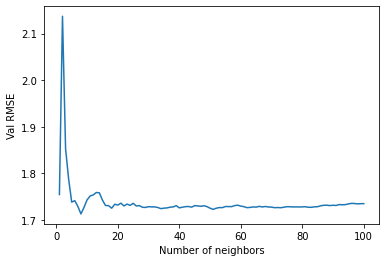

In [65]:
plt.plot(n_neighbors_space, val_rmse)
plt.xlabel('Number of neighbors')
plt.ylabel('Val RMSE')
plt.show()

In [66]:
print('Best K Neighbors:', best_n_neighbors)

Best K Neighbors: 8


In [67]:
z_val = hyper_propagation(X, y[idx_train], idx_train, idx_val, best_n_neighbors, pred_train=pred_train, pred_test=pred_val)
z_test = hyper_propagation(X, y[idx_train], idx_train, idx_test, best_n_neighbors, pred_train=pred_train, pred_test=pred_test)

In [68]:
val_rmse = mean_squared_error(y[idx_val], z_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], z_test, squared=False)

In [69]:
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Val RMSE: 1.7131728277712825
Test RMSE: 2.0305862375660233


## CatBoost

In [70]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 51 kB/s 


In [71]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

In [91]:
cb = CatBoostRegressor(iterations=1000,
                       random_state=42,
                       l2_leaf_reg=50,
                       learning_rate=0.01,
                       use_best_model=True)

In [92]:
cb.fit(X[idx_train], y[idx_train],
       eval_set=(X[idx_val], y[idx_val]))

0:	learn: 1.9963764	test: 1.9582015	best: 1.9582015 (0)	total: 26.6ms	remaining: 26.6s
1:	learn: 1.9935670	test: 1.9552688	best: 1.9552688 (1)	total: 38.5ms	remaining: 19.2s
2:	learn: 1.9909023	test: 1.9526284	best: 1.9526284 (2)	total: 49.5ms	remaining: 16.4s
3:	learn: 1.9882435	test: 1.9497171	best: 1.9497171 (3)	total: 59.6ms	remaining: 14.8s
4:	learn: 1.9858921	test: 1.9473888	best: 1.9473888 (4)	total: 70.9ms	remaining: 14.1s
5:	learn: 1.9831377	test: 1.9443670	best: 1.9443670 (5)	total: 81.2ms	remaining: 13.4s
6:	learn: 1.9801199	test: 1.9414499	best: 1.9414499 (6)	total: 92.3ms	remaining: 13.1s
7:	learn: 1.9772546	test: 1.9386670	best: 1.9386670 (7)	total: 108ms	remaining: 13.4s
8:	learn: 1.9745568	test: 1.9362598	best: 1.9362598 (8)	total: 121ms	remaining: 13.3s
9:	learn: 1.9715783	test: 1.9331222	best: 1.9331222 (9)	total: 133ms	remaining: 13.1s
10:	learn: 1.9689323	test: 1.9304643	best: 1.9304643 (10)	total: 143ms	remaining: 12.8s
11:	learn: 1.9663605	test: 1.9277717	best: 1.

In [93]:
pred_train = cb.predict(X[idx_train]).reshape(-1, 1)
pred_val = cb.predict(X[idx_val]).reshape(-1, 1)
pred_test = cb.predict(X[idx_test]).reshape(-1, 1)

In [94]:
train_rmse = mean_squared_error(y[idx_train], pred_train, squared=False)
val_rmse = mean_squared_error(y[idx_val], pred_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], pred_test, squared=False)

In [95]:
print('Train RMSE:', train_rmse)
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 1.6371275648898376
Val RMSE: 1.6841887158642956
Test RMSE: 1.945340219489591


In [96]:
n_neighbors_space = np.arange(1, 101)
val_rmse = []
best_rmse = 1e9
best_n_neighbors = n_neighbors_space[0]
for n_neighbors in tqdm(n_neighbors_space):
    z = hyper_propagation(X, y[idx_train], idx_train, idx_val, n_neighbors, pred_train=pred_train, pred_test=pred_val)
    val_rmse.append(mean_squared_error(y[idx_val], z, squared=False))
    if val_rmse[-1] < best_rmse:
        best_n_neighbors = n_neighbors
        best_rmse = val_rmse[-1]

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


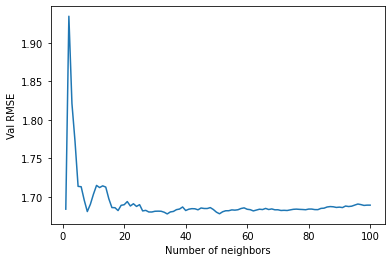

In [97]:
plt.plot(n_neighbors_space, val_rmse)
plt.xlabel('Number of neighbors')
plt.ylabel('Val RMSE')
plt.show()

In [98]:
print('Best K Neighbors:', best_n_neighbors)

Best K Neighbors: 34


In [99]:
z_val = hyper_propagation(X, y[idx_train], idx_train, idx_val, best_n_neighbors, pred_train=pred_train, pred_test=pred_val)
z_test = hyper_propagation(X, y[idx_train], idx_train, idx_test, best_n_neighbors, pred_train=pred_train, pred_test=pred_test)

In [100]:
val_rmse = mean_squared_error(y[idx_val], z_val, squared=False)
test_rmse = mean_squared_error(y[idx_test], z_test, squared=False)

In [101]:
print('Val RMSE:', val_rmse)
print('Test RMSE:', test_rmse)

Val RMSE: 1.6780225895951666
Test RMSE: 1.9199001877585002
